In [1]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import tensorflow as tf
 
import requests

In [16]:
#getting the file directories for x=features and y=masks

data_dir = 'D:/Hamed/Forschungsproject/UNet/test'

x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('.png'):
        if not filename.endswith('_seg.png'):
            x.append(os.path.join(data_dir, filename))
        else:
            y.append(os.path.join(data_dir, filename))



In [58]:
# for filename in y:
#     img = Image.open(os.path.join(data_dir, filename))
#     img = img.resize((256,256))
#     img = img.convert('L')
#     img_arr = np.array(img,dtype=np.float32)
#     print(np.unique(img_arr))

In [17]:
# Load x images
x_images = []
for filename in x:
    img = Image.open(os.path.join(data_dir, filename))
    img = img.resize((256,256))
    img = img.convert('L')
    img_arr = np.array(img,dtype=np.float32)
    img_arr = np.divide(img_arr,np.max(img_arr))
    x_images.append(img_arr)

# Load y images
y_images = []
for filename in y:
    img = Image.open(os.path.join(data_dir, filename))
    img = img.resize((256,256))
    img = img.convert('L')
    img_arr = np.array(img,dtype=np.float32)
    img_arr[img_arr < 125] = 0
    img_arr[img_arr >= 125] = 1
    y_images.append(img_arr)
    


In [18]:
#spliting the data

testno = int(len(x) * (80/100)) 
valno = int(testno + len(x) * (10/100))
trainno = int(valno + len(x) * (10/100))

x_train, y_train = np.array(x_images[:testno],dtype=np.float32), np.array(y_images[:testno],dtype=np.float32)
x_val, y_val = np.array(x_images[testno:valno],dtype=np.float32), np.array(y_images[testno:valno],dtype=np.float32)
x_test, y_test = np.array(x_images[valno:trainno],dtype=np.float32), np.array(y_images[valno:trainno],dtype=np.float32)

# Print number of samples in each set
print('Number of samples in training set:', len(x_train))
print('Number of samples in validation set:', len(x_val))
print('Number of samples in test set:', len(x_test))

Number of samples in training set: 2800
Number of samples in validation set: 350
Number of samples in test set: 350


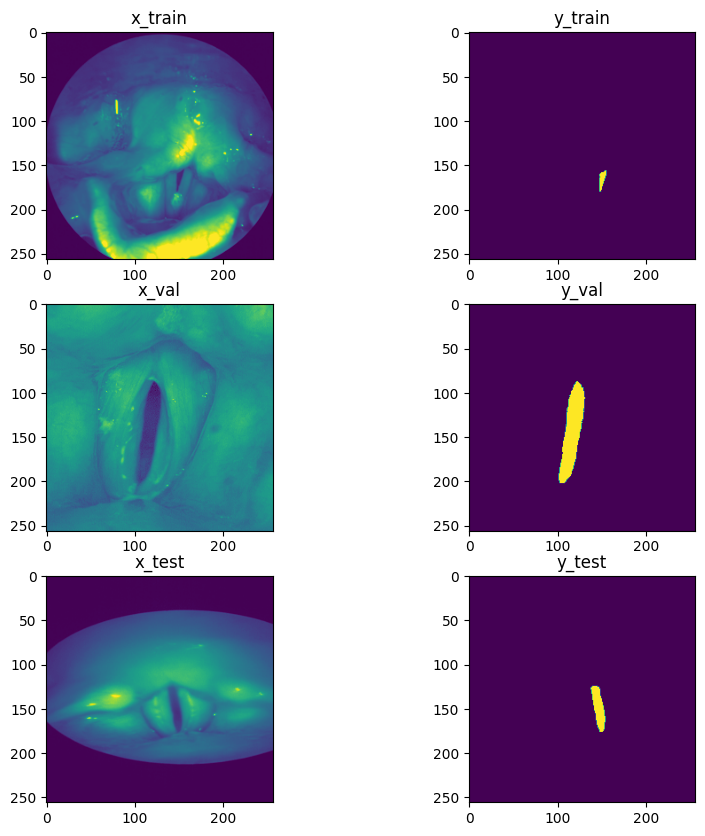

In [21]:
x = np.random.randint(0,350)
datas = ([x_train, y_train],[x_val, y_val],[x_test, y_test])
cap = (['x_train', 'y_train'],['x_val', 'y_val'],['x_test', 'y_test'])
i = 3
j = 2
fig, axs = plt.subplots(i, j, figsize=(10, 10))

ix = -1
for ix in range(i):
    for jx in range(j):
        axs[ix,jx].imshow(datas[ix][jx][x])
        axs[ix,jx].set_title(cap[ix][jx])
        axs[ix,jx].imshow(datas[ix][jx][x])
        axs[ix,jx].set_title(cap[ix][jx])
        

plt.show()

In [20]:
print(f'max value for images is {np.max(x_images)} and for masks {np.max(y_images)}')
print(f'min value for images is {np.min(x_images)} and for masks {np.min(y_images)}')
print(f'number of unique values in images is {len(np.unique(x_images[x]))} and for masks {np.unique(y_images[x])}')

max value for images is 1.0 and for masks 1.0
min value for images is 0.0 and for masks 0.0
number of unique values in images is 238 and for masks [0. 1.]


In [39]:

inputs = Input((256, 256,1))


# Contractive
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)


# Expansive 
upconv1 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
up6 = UpSampling2D(size = (2,2))(upconv1)
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

upconv2 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = UpSampling2D(size = (2,2))(upconv2)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

upconv3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = UpSampling2D(size = (2,2))(upconv3)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)


upconv4 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = UpSampling2D(size = (2,2))(upconv4)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)


conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

#model.summary()




In [8]:
class BotCallback(tf.keras.callbacks.Callback):
    logs_arr = []
    def __init__(self, personal_token=None):
        self.personal_token = '5964545787:AAEQH7xnHonOarFiILcsftnbryRmOqWyCFk'
        self.ping_url = 'https://api.telegram.org/bot'+str(self.personal_token)+'/getUpdates'
        self.response = requests.get(self.ping_url).json()
        self.chat_id = self.response['result']

    def send_message(self,message):
        self.ping_url = 'https://api.telegram.org/bot'+str(self.personal_token)+'/sendMessage?'+\
                        'chat_id='+str(self.chat_id)+\
                        '&parse_mode=Markdown'+\
                        '&text='+message
        self.response = requests.get(self.ping_url)

    def on_epoch_end(self, epoch, logs):
        ac = logs['accuracy']
        loss = logs['loss']
        text = f"*Epoch*: {str(epoch)}\nAccuracy: {str(ac)}\nloss: {str(loss)}."
        self.send_message(f'{epoch}, {logs}') 
        if epoch == 9:
            self.send_message("*THE END*") 
            
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001,
    patience=3,
    verbose=1, 
    mode='auto' 
)

In [34]:
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

loss = DiceLoss()
metric = IOUScore()


In [40]:
model.compile(optimizer = 'Adam', loss = loss, metrics = [metric])
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], epochs=20, batch_size=30)

Epoch 1/20
94/94 [==============================] - 10s 83ms/step - loss: 0.7517 - iou_score: 0.1740 - val_loss: 0.2843 - val_iou_score: 0.5572
Epoch 2/20
94/94 [==============================] - 7s 69ms/step - loss: 0.2019 - iou_score: 0.6715 - val_loss: 0.1447 - val_iou_score: 0.7459
Epoch 3/20
94/94 [==============================] - 7s 71ms/step - loss: 0.1076 - iou_score: 0.8076 - val_loss: 0.0928 - val_iou_score: 0.8288
Epoch 4/20
94/94 [==============================] - 7s 69ms/step - loss: 0.0812 - iou_score: 0.8504 - val_loss: 0.0751 - val_iou_score: 0.8588
Epoch 5/20
94/94 [==============================] - 7s 69ms/step - loss: 0.0708 - iou_score: 0.8682 - val_loss: 0.0764 - val_iou_score: 0.8569
Epoch 6/20
94/94 [==============================] - 6s 69ms/step - loss: 0.0619 - iou_score: 0.8838 - val_loss: 0.0653 - val_iou_score: 0.8761
Epoch 7/20
94/94 [==============================] - 7s 71ms/step - loss: 0.0594 - iou_score: 0.8878 - val_loss: 0.0620 - val_iou_score: 0.881

In [56]:
#history.history

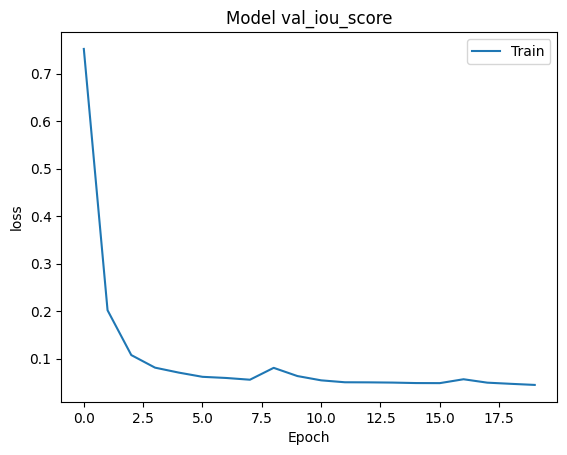

In [58]:
#how was the network on each epoch?

plt.plot(history.history['loss'])
plt.title('Model val_iou_score')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [41]:
y_pred = model.predict(x_test)

score = model.evaluate(x_test, y_test)
np.shape(y_pred)

11/11 [==============================] - 0s 29ms/step - loss: 0.0586 - iou_score: 0.8896


(350, 256, 256, 1)

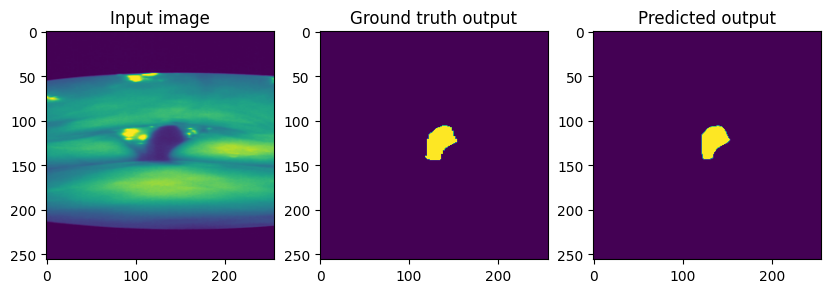

array([0.0000000e+00, 1.1796953e-38, 1.1803616e-38, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

In [54]:
# Choose an index i to plot
i = random_num = np.random.randint(0,300)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the input image in the first subplot
axs[0].imshow(x_test[i])
axs[0].set_title('Input image')

# Plot the ground truth output in the second subplot
axs[1].imshow(y_test[i])
axs[1].set_title('Ground truth output')

# Plot the predicted output in the third subplot
axs[2].imshow(y_pred[i])
axs[2].set_title('Predicted output')

# Show the figure
plt.show()

np.unique(y_pred[i])